<a href="https://colab.research.google.com/github/claudio1975/Medium-blog/blob/master/Langchain_%26_OpenAI_in_Action/Document_Data_Analysis_with_LangChain_%26_OpenAI_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Libraries and prepare Workspace

datasource: https://arxiv.org/abs/2205.10785

The paper "Responsible Artificial Intelligence -- from Principles to Practice" by Virginia Dignum introduces the topic of ethical AI.

Responsible AI implementation depends not only on technological advancements but also on how AI systems are introduced and used in society.

Understanding AI involves knowing its capabilities, addressing risks, and ensuring all stakeholders have a clear understanding of AI applications.







In [ ]:
# Install the langchain package
!pip install langchain &> /dev/null

In [ ]:
# Install the langchain package with openai
!pip install -U langchain-openai &> /dev/null

In [ ]:
# Install the faiss
!pip install faiss-cpu &> /dev/null

In [ ]:
# Install the tiktoken
!pip install tiktoken &> /dev/null

In [ ]:
# Install the pypdf package
!pip install pypdf &> /dev/null

In [ ]:
# Import the os package
import os
# Import the openai package
import openai
# Set openai.api_key to the OPENAI_API_KEY environment variable
os.environ["OPENAI_API_KEY"] = ""

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
# Import the langchain package and modules
import langchain as lc
from langchain_openai import ChatOpenAI
from langchain.chains import RetrievalQA
from langchain.document_loaders import PyPDFLoader
from transformers import GPT2TokenizerFast
from langchain_openai import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain.schema import Document
# From the langchain.schema module, import AIMessage, HumanMessage, SystemMessage
from langchain.schema import AIMessage, HumanMessage, SystemMessage

In [ ]:
# From the IPython.display package, import display and Markdown
from IPython.display import display, Markdown

In [ ]:
# Create a ChatOpenAI object. Assign to chat.
chat = ChatOpenAI(temperature=0, model_name='gpt-3.5-turbo')

In [ ]:
lc.__version__

'0.1.7'

In [ ]:
openai.__version__

'1.12.0'

### Have a look of the paper

In [ ]:
# Load content from local PDFs
loader = PyPDFLoader("./responsible_AI.pdf")
pdf_data = loader.load()

In [ ]:
# Define the document:
Document(page_content="Let's imagine this is a huge document with a lot of words and important stuff.",
         metadata={
             'document_id' : 0000,
             'document_source' : "arxiv",
             'document_create_time' : "22/05/2022"
         })


Document(page_content="Let's imagine this is a huge document with a lot of words and important stuff.", metadata={'document_id': 0, 'document_source': 'arxiv', 'document_create_time': '22/05/2022'})

In [ ]:
print("\nPage Content: ", pdf_data[0].page_content)
print("\nMeta Data: ", pdf_data[0].metadata)


Page Content:  arXiv:2205.10785v1  [cs.CY]  22 May 2022PAPER
Responsible Artiﬁcial Intelligence – from
Principles to Practice
Virginia Dignum
Ume˚ a University
Sweden
virginia@cs.umu.se
Abstract
The impact of Artiﬁcial Intelligence does not depend only on fundamental research and
technological developments, but for a large part on how thes e systems are introduced into
society and used in everyday situations. AI is changing the w ay we work, live and solve
challenges but concerns about fairness, transparency or pr ivacy are also growing. Ensuring
responsible,ethical AIismorethandesigningsystemswhos eresultcanbetrusted. Itisabout
thewaywedesignthem, whywedesignthem, andwhoisinvolved indesigningthem. Inorder
to develop and use AI responsibly, we need to work towards tec hnical, societal, institutional
and legal methods and tools which provide concrete support t o AI practitioners, as well as
awareness and training to enable participation of all, to en sure the alignment of AI systems
wi

### Splitting Text

In [ ]:
# Advanced method - Split by chunks
# Create function to count tokens
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")

def count_tokens(text: str) -> int:
    return len(tokenizer.encode(text))

# Define the splitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size      = 1500,
    chunk_overlap   = 200,
    length_function = count_tokens # It uses len() by default.
)

# Apply the .split_document command
pdf_chunks = text_splitter.split_documents(pdf_data)
print("PDF Splited by Chunks - You have {0} number of chunks.".format(len(pdf_data)))


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

PDF Splited by Chunks - You have 6 number of chunks.


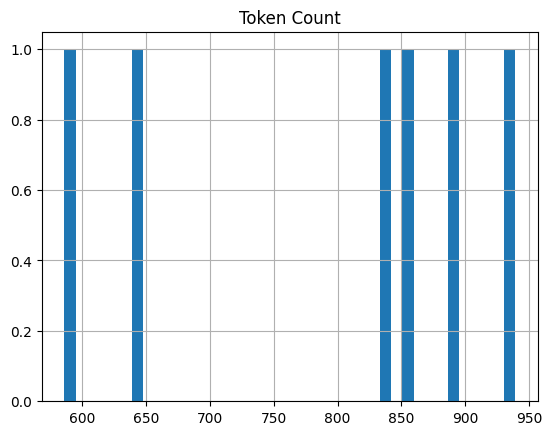

In [ ]:
# Data visualization about chunking

# Create a list of token counts
token_counts = [count_tokens(chunk.page_content) for chunk in pdf_chunks]

# Create a DataFrame from the token counts
df = pd.DataFrame({'Token Count': token_counts})

# Create a histogram of the token count distribution
df.hist(bins=40, )

# Show the plot
plt.show()

In [ ]:
# Simple method - Split by pages
pdf_pages_chunks = loader.load_and_split()
pdf_pages_chunks
print("PDF Splited by Pages - You have {0} number of pages.".format(len(pdf_pages_chunks)))

PDF Splited by Pages - You have 6 number of pages.


### Embedding and Upload the data into a VectorStore

In [ ]:
embeddings = OpenAIEmbeddings()
# Create vector database
db_FAISS = FAISS.from_documents(pdf_chunks, embeddings)

### Q&A Analysis

In [ ]:
# Function Q&A
def asking_your_model(query):
  retriever = db_FAISS.as_retriever(search_type="similarity_score_threshold", search_kwargs={"score_threshold": 0.6})
  # Create a chain to answer questions
  qa = RetrievalQA.from_chain_type(
    llm=chat, chain_type="stuff", retriever=retriever, return_source_documents=True)
  result = qa.invoke({'query': query})
  response=result['result'].split('\n')
  return response


In [ ]:
def sources(query):
     # Define the retriever
     retriever = db_FAISS.as_retriever(search_type="similarity_score_threshold", search_kwargs={"score_threshold": 0.6})
     matches= retriever.get_relevant_documents(query)
     print("We found {0} number of similarities.".format(len(matches)))
     return matches

In [ ]:
query = "Could you summarize the paper in bullet points?"
display(asking_your_model(query))

['- The paper discusses the importance of responsible development and use of Artificial Intelligence (AI).',
 '- There are over 600 AI-related policy recommendations and guidelines, but more work is needed to ensure responsible AI development.',
 '- The paper emphasizes the need to consider ethical, legal, and societal principles in AI development and use.',
 '- AI should be understood as a socio-technical ecosystem, considering the interaction between people and technology.',
 '- The paper highlights the importance of addressing biased data, power structures, and societal and environmental costs in AI systems.',
 '- Understanding what AI is and what it can and cannot do is crucial for responsible AI governance.',
 '- AI is not just about data and algorithms, but also about the choices made by developers and the impact on society.',
 '- The paper calls for a proper AI narrative that demystifies AI and enables inclusive participation in discussions about its role in society.']

In [ ]:
display(sources(query))

We found 4 number of similarities.


[Document(page_content='arXiv:2205.10785v1  [cs.CY]  22 May 2022PAPER\nResponsible Artiﬁcial Intelligence – from\nPrinciples to Practice\nVirginia Dignum\nUme˚ a University\nSweden\nvirginia@cs.umu.se\nAbstract\nThe impact of Artiﬁcial Intelligence does not depend only on fundamental research and\ntechnological developments, but for a large part on how thes e systems are introduced into\nsociety and used in everyday situations. AI is changing the w ay we work, live and solve\nchallenges but concerns about fairness, transparency or pr ivacy are also growing. Ensuring\nresponsible,ethical AIismorethandesigningsystemswhos eresultcanbetrusted. Itisabout\nthewaywedesignthem, whywedesignthem, andwhoisinvolved indesigningthem. Inorder\nto develop and use AI responsibly, we need to work towards tec hnical, societal, institutional\nand legal methods and tools which provide concrete support t o AI practitioners, as well as\nawareness and training to enable participation of all, to en sure the al

In [ ]:
query = "How can responsible AI development be defined and what are the key components involved in ensuring ethical AI practices?"
display(asking_your_model(query))

['Responsible AI development refers to the process of designing, developing, and using AI systems in a way that aligns with ethical principles and societal values. It involves taking into account the potential impact of AI on individuals and society as a whole, and ensuring that AI systems are transparent, fair, accountable, and respectful of privacy.',
 '',
 'Key components involved in ensuring ethical AI practices include:',
 '',
 '1. Responsibility and Accountability: Developers and organizations involved in AI development should take responsibility for the decisions and actions of AI applications. They should be accountable for the potential harms caused by AI systems and should have mechanisms in place to address any negative consequences.',
 '',
 '2. Transparency: AI systems should be transparent, meaning that their decision-making processes and underlying algorithms should be explainable and understandable to users and stakeholders. Transparency helps build trust and allows for 

In [ ]:
display(sources(query))

We found 4 number of similarities.


[Document(page_content='3 Responsible AI - The question zero\nResponsible AI (or Ethical AI, or Trustworthy AI) is not, as some m ay claim, a way to give\nmachines some kind of ‘responsibility’ for their actions and decisions, and in the process discharge\npeople and organisations of their responsibility. On the contrary, r esponsible development and\nuse of AI requires more responsibility and more accountability from t he people and organisations\ninvolved: for the decisions and actions of the AI applications, and fo r their own decision of using\nAI in a given application context [ Dignum,2022]. When considering eﬀects and the governance\nthereof, the technology, or the artefact that embeds that tec hnology, cannot be separated from\nthe socio-technical ecosystem of which it is a component. Guidelines , principles and strategies\nto ensure trust and responsibility in AI, must be directed towards t he socio-technical ecosystem\nin which AI is developed and used. It is not the AI artef

In [ ]:
query="How can the Glass Box framework contribute to transparency and value-based design in AI development, and what are the potential benefits of this approach for responsible AI implementation?"
display(asking_your_model(query))

['The Glass Box framework, developed by Aler Tubella and Dignum, is a comprehensive approach to software development that integrates verification with value-based design. It aims to enhance transparency and ensure that AI systems align with human values.',
 '',
 "The framework contributes to transparency by providing a high-level view of the system's functionality and how it adheres to the identified values. It allows stakeholders to understand how the system interprets and prioritizes values in its decision-making processes. This transparency helps build trust and accountability in AI systems.",
 '',
 "Value-based design is another key aspect of the Glass Box framework. It involves eliciting and representing stakeholders' values and expectations and linking them to formal system requirements and concrete functionalities. This approach ensures that the design process considers the societal values and moral considerations relevant to the AI system's application context.",
 '',
 'The pot

In [ ]:
display(sources(query))

We found 4 number of similarities.


[Document(page_content='Achieving trustworthy AI systems is a multifaceted complex proces s, which requires both tech-\nnical and socio-legal initiatives and solutions to ensure that we alway s align an intelligent system’s\ngoals with human values. Core values, as well as the processes used for value elicitation, must be\nmade explicit and that all stakeholders are involved in this process. F urthermore, the methods\nused for the elicitation processes and the decisions of who is involved in the value identiﬁcation\nprocess must be clearly identiﬁed and documented.\nWhere it concerns the design process itself, responsibility includes t he need to elicit and rep-\nresent stakeholders, their values and expectations, as well as en suring transparency about how\nsuch values are interpreted and prioritised in the concrete functio nalities of the AI system. Design\nfor Values methodologies [ van den Hoven ,2005;Friedman et al. ,2006] are often used for this end,\nproviding a structured way f

In [ ]:
query="What are the challenges associated with bias, transparency, and accountability in AI systems, and how can these challenges be addressed?"
display(asking_your_model(query))

['The challenges associated with bias, transparency, and accountability in AI systems are significant and require careful consideration. ',
 '',
 "1. Bias: AI systems can inherit biases from the data they are trained on, leading to discriminatory outcomes. Addressing bias requires careful data selection and preprocessing, as well as ongoing monitoring and evaluation of the system's performance. It is important to involve diverse stakeholders in the design and development process to ensure a broader perspective and mitigate bias.",
 '',
 '2. Transparency: Many AI systems, such as deep learning models, are often considered "black boxes" because their decision-making processes are not easily interpretable. This lack of transparency raises concerns about how decisions are made and whether they align with human values. Addressing transparency requires the development of explainable AI techniques that provide insights into the system\'s decision-making process. This can involve techniques su

In [ ]:
display(sources(query))

We found 4 number of similarities.


[Document(page_content='Achieving trustworthy AI systems is a multifaceted complex proces s, which requires both tech-\nnical and socio-legal initiatives and solutions to ensure that we alway s align an intelligent system’s\ngoals with human values. Core values, as well as the processes used for value elicitation, must be\nmade explicit and that all stakeholders are involved in this process. F urthermore, the methods\nused for the elicitation processes and the decisions of who is involved in the value identiﬁcation\nprocess must be clearly identiﬁed and documented.\nWhere it concerns the design process itself, responsibility includes t he need to elicit and rep-\nresent stakeholders, their values and expectations, as well as en suring transparency about how\nsuch values are interpreted and prioritised in the concrete functio nalities of the AI system. Design\nfor Values methodologies [ van den Hoven ,2005;Friedman et al. ,2006] are often used for this end,\nproviding a structured way f

### Prepare the contest for GPT

In [ ]:
pdf1=pd.DataFrame([pdf_data[0].page_content], columns=['content'])
pdf2=pd.DataFrame([pdf_data[1].page_content], columns=['content'])
pdf3=pd.DataFrame([pdf_data[2].page_content], columns=['content'])
pdf4=pd.DataFrame([pdf_data[3].page_content], columns=['content'])
pdf5=pd.DataFrame([pdf_data[4].page_content], columns=['content'])
pdf6=pd.DataFrame([pdf_data[5].page_content], columns=['content'])
df=pd.concat([pdf1,pdf2,pdf3,pdf4,pdf5,pdf6], axis=0)

In [ ]:
# A description of the document

document_description = """
You have a dataframe called 'df' in a pandas dataframe retrieved from the paper respnsible_AI, it contains the six pages in six rows.
"""

In [ ]:
# Concatenate the document description and the context.
msgs_context = [
                SystemMessage(content="You are an expert data scientist, and you are involved in a NLP Topic Modelling analysis."),
                HumanMessage(content=f"{document_description}")
]

### Use GPT as code assistant to run a data analysis on the data set

#### Topic Modelling

In [ ]:
# Ask GPT to provide code for a topic modelling content
msgs_python_topic = msgs_context+[
    HumanMessage(content=
"""
Write some Python code to make a topic modelling analysis on 'df' dataframe, column 'content'.\
Pleae clean the text, by tokenization, removing the stop words, removing unicode characters, removing punctuaction and numbers, and apply lemmatization.\
Every word have at least five characters.\
Shows max 5 topic with 10 words.\
Use nltk package and gensim packages for pre-processing.\
Use gensim package and LDA for topic modelling.
""")]

rsps_python_topic = chat.invoke(msgs_python_topic)

display(Markdown(rsps_python_topic.content))

Sure! Here's the Python code to perform topic modelling analysis on the 'df' dataframe using the specified preprocessing steps and the gensim package for topic modelling:

```python
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim import corpora
from gensim.models import LdaModel

# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Load the dataframe
df = pd.read_csv('respnsible_AI.csv')

# Define the preprocessing function
def preprocess_text(text):
    # Tokenization
    tokens = word_tokenize(text.lower())
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Remove unicode characters
    tokens = [token.encode('ascii', 'ignore').decode('utf-8') for token in tokens]
    
    # Remove punctuation and numbers
    tokens = [token for token in tokens if token.isalpha() and len(token) >= 5]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return tokens

# Apply preprocessing to the 'content' column
df['clean_content'] = df['content'].apply(preprocess_text)

# Create a dictionary representation of the documents
dictionary = corpora.Dictionary(df['clean_content'])

# Create a corpus (bag of words) representation of the documents
corpus = [dictionary.doc2bow(text) for text in df['clean_content']]

# Train the LDA model
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, passes=10)

# Print the topics and their top 10 words
for topic_id, topic_words in lda_model.print_topics(num_topics=5, num_words=10):
    print(f'Topic {topic_id + 1}: {topic_words}')

```

Make sure to replace `'respnsible_AI.csv'` with the actual file path of your CSV file containing the dataframe.

In [ ]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim import corpora
from gensim.models import LdaModel

# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Load the dataframe
#df = pd.read_csv('respnsible_AI.csv')

# Define the preprocessing function
def preprocess_text(text):
    # Tokenization
    tokens = word_tokenize(text.lower())

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Remove unicode characters
    tokens = [token.encode('ascii', 'ignore').decode('utf-8') for token in tokens]

    # Remove punctuation and numbers
    tokens = [token for token in tokens if token.isalpha() and len(token) >= 5]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return tokens

# Apply preprocessing to the 'content' column
df['clean_content'] = df['content'].apply(preprocess_text)

# Create a dictionary representation of the documents
dictionary = corpora.Dictionary(df['clean_content'])

# Create a corpus (bag of words) representation of the documents
corpus = [dictionary.doc2bow(text) for text in df['clean_content']]

# Train the LDA model
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, passes=10)

# Print the topics and their top 10 words
for topic_id, topic_words in lda_model.print_topics(num_topics=5, num_words=10):
    print(f'Topic {topic_id + 1}: {topic_words}')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Topic 1: 0.002*"value" + 0.002*"system" + 0.002*"design" + 0.002*"power" + 0.002*"algorithm" + 0.002*"development" + 0.002*"decision" + 0.002*"responsibility" + 0.001*"approach" + 0.001*"societal"
Topic 2: 0.019*"power" + 0.017*"technology" + 0.011*"system" + 0.011*"decide" + 0.011*"choice" + 0.011*"structure" + 0.009*"decision" + 0.009*"ensure" + 0.009*"people" + 0.009*"societal"
Topic 3: 0.022*"value" + 0.020*"system" + 0.016*"responsibility" + 0.012*"design" + 0.011*"responsible" + 0.011*"ethical" + 0.011*"approach" + 0.010*"development" + 0.010*"decision" + 0.009*"principle"
Topic 4: 0.002*"algorithm" + 0.001*"responsible" + 0.001*"system" + 0.001*"value" + 0.001*"intelligence" + 0.001*"design" + 0.001*"development" + 0.001*"result" + 0.001*"decision" + 0.001*"innovation"
Topic 5: 0.016*"algorithm" + 0.010*"system" + 0.010*"responsible" + 0.010*"intelligence" + 0.008*"value" + 0.008*"power" + 0.006*"design" + 0.006*"choice" + 0.006*"innovation" + 0.006*"dignum"
